# Machine Learning Project : LDA (Linear Discrimination Analysis)

Class: Introduction to Machine Learning

Team 11: Julian Nunez Nova, Kirill Savin


# Introduction 

Key objectives of the project:

1. Select a supervised machine learning classification algorithm.

2. Study it in detail (theoretically and empirically).

3. Identify a data characteristic that affects its performance.

4. Propose a variant of the algorithm that addresses this weakness.

5. Evaluate the modified version on the OpenML-CC18 benchmark datasets.


----

<br></br>

In this project, we selected Linear Discriminant Analysis (LDA) and focused on the characteristic noise/outliers, which LDA is known to be sensitive to. As a classic algorithm, LDA relies heavily on accurate estimates of class means and a shared covariance matrix, making its performance vulnerable to distortions caused by extreme values in the training data.

This project investigates the robustness of standard LDA against synthetic outliers and proposes a robust variant designed to mitigate this sensitivity. The core research questions are:

- To what extent does the performance of standard LDA degrade when outliers are introduced into the training data?

- Can a variant of LDA, based on a robust covariance estimator, reduce this degradation and improve overall model
stability?


To address these questions, we conduct an empirical study comparing the standard LDA with our proposed robust variant
 across multiple datasets from the **OpenML-CC18 benchmark**. The evaluation follows a structured pipeline, including
 data preprocessing, synthetic outlier injection, and performance assessment via stratified cross-validation using Accuracy and Macro F1-score. This analysis aims to quantify the degradation of standard LDA under noise and demonstrate the effectiveness of our robust adaptation.


# Background

**Linear Discriminant Analysis (LDA)** is a classification and dimensionality reduction algorithm that allows for the
 optimal separation of classes. The goal and principle of LDA is to linearly combine the features of the data so that
 the labels
 of the datasets are best separated from each other, and the number of new features is reduced to a predefined count.

<img src="images/lda_goal.png" alt="LDA" style="width:4500px; height:350px; object-fit:contain; display:block;
margin:0 auto;" />


## LDA in scratch

The process of Linear Discriminant Analysis (LDA) can be broken down into five key steps.
<br></br>
##### **Step 1:** Compute the d-dimensional mean vectors for each of the k classes separately from the dataset.


LDA is a supervised machine learning technique, meaning we can utilize the known labels. In the first step, we
calculate the mean vectors $mean_c$ for all samples belonging to a specific class $c$. To do this, we filter the feature matrix by class label and compute the mean for each of the $d$ features. As a result, we obtain $k$ mean vectors (one for each of the $k$ classes), each with a length of $d$ (corresponding to the $d$ features).

<img src="images/feature_matrix.png" alt="LDA" style="width:950px; height:350px; object-fit:contain; display:block;
margin:0 auto;" />

$$
\text{mean}_c = \frac{1}{n_c - 1} \cdot \sum_{x \in C_c} \mathbf{X}_c = [\mu_1, \mu_2, \mu_3, \ldots, \mu_d]
$$

Where:

$ \mu_c = [\mu_1, \mu_2, \mu_3, \dots, \mu_d] $ is the $d$-dimensional mean vector

$ \mu_j $ is the mean of the $ j $-th feature for class $c$

$ n_c $ is the number of samples in class $c$

$ C_c $ - the set of all samples in class $c$

$ x $ - the sample vector



##### **Step 2:** Compute the scatter matrices (between-class scatter matrix and within-class scatter matrix).



The within-class scatter matrix measures the variation among samples within the same class. To find a subspace with optimal separability, we aim to minimize the values in this matrix. In contrast, the between-class scatter matrix measures the variation between different classes. For optimal separability, we aim to maximize the values in this matrix.

Intuitively, within-class scatter looks at how compact each class is, whereas between-class scatter examines how far apart different classes are.


<img src="images/class_scatter_matrices.png" alt="LDA" style="width:450px; height:350px; object-fit:contain;
display:block;
margin:0 auto;" />


The within-class scatter matrix S_W. It is calculated as the sum of the scatter matrices S_c for each individual class:

$$ S_w = \sum_{c=1}^k S_c  ,\  where \ \ \  S_c = \sum_{x \in C_c} (x - \text{mean}_c) \cdot (x - \text{mean}_c)^T $$


The between-class scatter matrix $S_B$ is derived from the differences between the class means $mean_c$ and the overall
mean of the entire dataset:
$$ S_B = \sum_{c=1}^k n_c \cdot (\text{mean}_c - \text{mean}) \cdot (\text{mean}_c - \text{mean})^T $$

where mean refers to the mean vector calculated over all samples, regardless of their class labels.



#### **Step 3:** Calculate the eigenvectors and eigenvalues for the ratio of $S_W$ and $S_B$.

As mentioned, for optimal class separability, we aim to maximize $S_B$ and minimize $S_W$. We can achieve both by
maximizing the ratio $S_B/S_W$. In linear algebra terms, this ratio corresponds to the scatter matrix $S_W^{-1}$ $S_B$,
which is maximized in the subspace spanned by the eigenvectors with the highest eigenvalues. The eigenvectors define the directions of this subspace, while the eigenvalues represent the magnitude of the distortion. We will select the $m$ eigenvectors associated with the highest eigenvalues.

$$
A\nu = \lambda\nu \quad \text{with} \quad A = S_W^{-1} S_B
$$

#### **Step 4:** Sort the eigenvectors in descending order of their corresponding eigenvalues, and select the $m$eigenvectors with the largest eigenvalues to form a $d × m$ - dimensional transformation matrix $W$.

The goal is not only to project the data into a subspace that enhances class separability but also to reduce
dimensionality. The eigenvectors will define the axes of our new feature subspace. To decide which eigenvectors to discard for the lower-dimensional subspace, we need to examine their corresponding eigenvalues. In simple terms, the eigenvectors with the smallest eigenvalues contribute the least to class separation, and these are the ones we want to drop. The typical approach is to rank the eigenvalues in descending order and select the top $m$ eigenvectors. $m$ is a freely chosen parameter. The larger $m$, the less information is lost during the transformation.

After sorting the eigenpairs by decreasing eigenvalues and selecting the top $m$ pairs, the next step is to construct
the $d × m$ - dimensional transformation matrix $W$. This is done by stacking the m selected eigenvectors horizontally, resulting in the matrix $W$:

$$
W =
\begin{pmatrix}
e_1^{(1)} & e_1^{(2)} & \cdots \\
e_2^{(1)} & e_2^{(2)} & \cdots \\
\vdots & \vdots & \ddots \\
e_d^{(1)} & e_d^{(2)} & \cdots
\end{pmatrix}
$$

The first column of $W$ represents the eigenvector corresponding to the highest eigenvalue, the second column represents the eigenvector corresponding to the second highest eigenvalue, and so on.



#### **Step 5:** Use W to project the samples onto the new subspace.

In the final step, we use the d × m-dimensional transformation matrix W, which we composed from the top m selected eigenvectors, to project our samples onto the new subspace:

$$Z = X⋅W,$$

where $X$ is the initial $n × d$ - dimensional feature matrix representing our samples, and $Z$ is the newly
transformed $n × m$ - dimensional feature matrix in the new subspace. This means that the selected eigenvectors serve
as the “recipes” for transforming the original features into the new features (the Linear Discriminants): The eigenvector with the highest eigenvalue provides the transformation recipe for $LD1$, the eigenvector with the second highest eigenvalue corresponds to $LD2$, and so on.


<img src="images/eug_mx.png" alt="LDA" style="width:950px; height:350px; object-fit:contain;
display:block;
margin:0 auto;" />


## Datasets Description

We use datasets from the OpenML CC-18 Curated Classification Benchmark Suite, which contains diverse classification datasets standardized for ML evaluation.

We downloaded a total of 11 datasets from OpenML and filtered them down to 7 datasets that were the most appropriate to use for testing LDA algorithm.

The criteria we used to select the datasets to test were the following:

- Binary classification
- No missing target values
- Manageable feature dimensionality
- Has numeric features

### 1. Inspection

In [59]:
#Inspect datasets
import scipy
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score

DATA_DIR = "datasets"  

def load_arff_to_df(path):
    """Load an ARFF file into a pandas DataFrame, decoding bytes if needed."""
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    
    # Decode byte strings to normal strings
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
    
    return df, meta

def summarize_dataset(path):
    """Return a dict with key info about one dataset."""
    df, meta = load_arff_to_df(path)
    
    n_instances = df.shape[0]
    n_attributes = df.shape[1]
    
    # Assume last column is the target 
    target_name = df.columns[-1]
    y = df[target_name]
    n_classes = y.nunique()
    
    # Feature columns
    feature_cols = df.columns[:-1]
    
    # Count numeric vs categorical
    n_numeric = 0
    n_categorical = 0
    for attr_name in feature_cols:
        # Use meta to check nominal vs numeric
        attr_type = meta[attr_name][0]  
        if isinstance(attr_type, str) and attr_type.lower() in ["numeric", "real", "integer"]:
            n_numeric += 1
        else:
            n_categorical += 1
    
    return {
        "filename": os.path.basename(path),
        "target": target_name,
        "#instances": n_instances,
        "#attributes_total": n_attributes,
        "#features": len(feature_cols),
        "#classes": int(n_classes),
        "#numeric_features": n_numeric,
        "#categorical_features": n_categorical
    }

# Scan all .arff files
arff_files = glob.glob(os.path.join(DATA_DIR, "*.arff"))

summaries = [summarize_dataset(p) for p in arff_files]
df_summary = pd.DataFrame(summaries)

# Sort to make it easier to inspect
df_summary = df_summary.sort_values(by="#instances")

#Check for instances, features, and classes constraints
df_suitable = df_summary[
    (df_summary["#instances"] >= 200) &
    (df_summary["#instances"] <= 20000) &
    (df_summary["#features"] <= 100) &
    (df_summary["#classes"] >= 2)
].copy()

#Check tha dataset has numeric features
df_suitable = df_suitable[df_suitable["#numeric_features"] >= 1]
df_suitable




,filename,target,#instances,#attributes_total,#features,#classes,#numeric_features,#categorical_features
10,dataset9.arff,Class,569,31,30,2,30,0
6,dataset5.arff,Class,748,5,4,2,4,0
4,dataset3.arff,class,768,9,8,2,8,0
3,dataset2.arff,class,1000,21,20,2,7,13
2,dataset12.arff,Class,1055,42,41,2,41,0
9,dataset8.arff,Class,1941,34,33,2,33,0
8,dataset7.arff,Class,5404,6,5,2,5,0


#### Dataset Diversity: Size vs Dimensonality

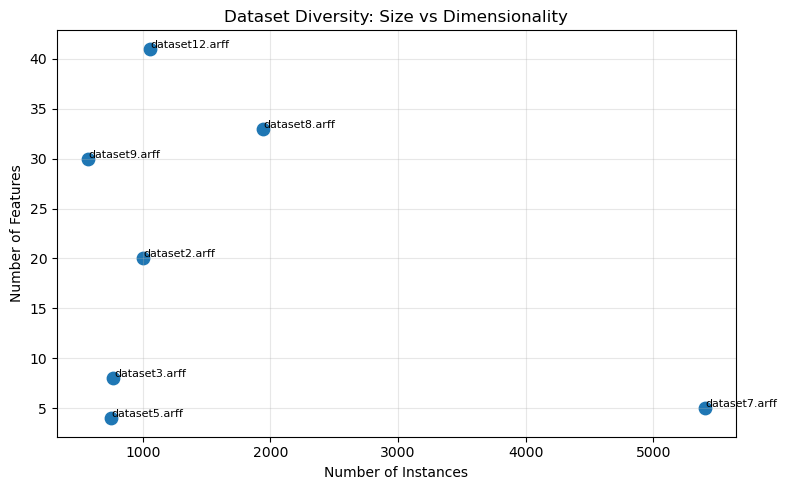

In [60]:


# df_summary is the table you created earlier
# It must contain: ["dataset", "#instances", "#features"]

plt.figure(figsize=(8, 5))

plt.scatter(df_suitable["#instances"], df_suitable["#features"], s=80)

# Add dataset labels next to each point
for _, row in df_suitable.iterrows():
    plt.text(row["#instances"] + 5, 
             row["#features"] + 0.1,
             row["filename"],
             fontsize=8)

plt.xlabel("Number of Instances")
plt.ylabel("Number of Features")
plt.title("Dataset Diversity: Size vs Dimensionality")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 2. Loading Datasets

Below we loaded all 7 datasets that we found suitable to test on and converted them into dataframes for further steps.

In [61]:
DATA_DIR = "datasets"

selected_files = [
    "dataset10.arff",
    "dataset6.arff",
    "dataset4.arff",
    "dataset3.arff",
    "dataset2.arff",
    "dataset9.arff",
    "dataset8.arff"
]

def load_dataset(fname):
    path = os.path.join(DATA_DIR, fname)
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    
    # decode byte strings
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
    
    target = df.columns[-1] 
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    return X, y, meta

# Test load
for f in selected_files:
    X, y, meta = load_dataset(f)
    print(f, X.shape, y.unique()[:5])


dataset10.arff (556, 6) ['1' '2']
dataset6.arff (601, 6) ['2' '1']
dataset4.arff (958, 9) ['positive' 'negative']
dataset3.arff (768, 8) ['tested_positive' 'tested_negative']
dataset2.arff (1000, 20) ['good' 'bad']
dataset9.arff (569, 30) ['2' '1']
dataset8.arff (1941, 33) ['1' '2']


### 3. Preprocessing
Before training LDA, each dataset undergoes a standardized preprocessing pipeline. The preprocessing step has two goals:

- Ensure all datasets share a consistent numerical representation

- Prevent feature scale imbalances and categorical encodings from biasing LDA

Because the datasets come from different sources, have different feature types, and use different value ranges, preprocessing is essential for obtaining fair and stable comparisons across the benchmark.

The preprocessing function below does the following:

- Identifies numerical and categorical features
- Numeric features are transformed using StandardScaler so that numeric features contribute equally to LDA’s decision boundary by applying: 
$$
x' = \frac{x - \mu}{\sigma}
$$
- Categorical features are encoded using OneHotEncoder so that LDA receives purely numeric input, even for mixed-type datasets.


In [62]:

def make_preprocessor(X):
    
     #Detect numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    #Categorical columns = everything else
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    print("Numeric columns:", numeric_cols)
    print("Categorical columns:", categorical_cols)

    #Define transformations
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    # Build ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessor


In [63]:
#Testing preprocessor on dataset
X, y, meta = load_dataset("dataset9.arff")

preprocessor = make_preprocessor(X)
X_proc = preprocessor.fit_transform(X)

print("Original shape:", X.shape)
print("Processed shape:", X_proc.shape)
print("Data type:", type(X_proc))



Numeric columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']
Categorical columns: []
Original shape: (569, 30)
Processed shape: (569, 30)
Data type: <class 'numpy.ndarray'>



# 4. Baseline Method: Standard Linear Discriminant Analysis (LDA)

## 4.1 Implementation and Preprocessing

We implement LDA using the `LinearDiscriminantAnalysis` class from scikit-learn, combined with the preprocessing pipeline described in the previous section.

For each dataset:
1. We load the ARFF file and split it into:
   - feature matrix \(X\)
   - target labels \(y\)
2. We build a dataset-specific preprocessing object using `make_preprocessor(X)`.
3. We evaluate LDA using **stratified 5-fold cross-validation**:
   - In each fold, the preprocessor is fit on the training data and applied to both train and test splits.
   - LDA is trained on the preprocessed training fold and evaluated on the preprocessed test fold.

This setup ensures a fair comparison across datasets and avoids data leakage between train and test folds.

## 4.2 Handling Noise and Outliers in the Baseline

To study the sensitivity of standard LDA to **noise and outliers**, we consider two experimental conditions for each dataset:

1. **Clean data**  
   - Original dataset, after preprocessing.
   - No artificial noise is added.

2. **Noisy data (with injected outliers)**  
   - We randomly select a fraction of the training samples (e.g., 10%).
   - For these samples, we add strong Gaussian noise to their feature vectors, producing extreme values.
   - Only the **training folds** are corrupted; test folds remain clean.

In both conditions, we computed:

- **Accuracy** – proportion of correctly classified test samples.
- **Macro F1-score** – F1-score averaged across classes, giving equal weight to each class and making it more sensitive to class imbalance.

These metrics allow us to quantify how much performance degrades when outliers are present in the training data.

### Outlier Injection Function

The outlier injection function below does the following: 
- Selects 10% of samples randomly (outlier_fraction)
- Adds strong noise (outlier_strength=5.0)

In [64]:
# OUTLIER INJECTION FUNCTION
def inject_outliers(X, y, outlier_fraction=0.1, outlier_strength=5.0):
    """
    Injects synthetic outliers by adding strong Gaussian noise to a fraction of the samples.
    Only adds noise to X (not y).
    """
    X_noisy = X.copy()
    n_samples = X_noisy.shape[0]
    n_outliers = int(outlier_fraction * n_samples)

    if n_outliers == 0:
        return X_noisy, y

    outlier_idx = np.random.choice(n_samples, size=n_outliers, replace=False)
    noise = np.random.normal(loc=0.0, scale=outlier_strength, size=X_noisy[outlier_idx].shape)

    X_noisy[outlier_idx] = X_noisy[outlier_idx] + noise

    return X_noisy, y


### Evaluation Function for LDA

The function below evaluates LDA on one dataset using stratified 5-fold cross-validation, with an option to inject outliers into the training data.

It returns:
- mean accuracy across folds
- mean macro F1-score across folds

In [65]:
#EVALUATION FUNCTION FOR LDA
def evaluate_lda_on_dataset(X, y, preprocessor, inject_noise=False, 
                            outlier_fraction=0.1, outlier_strength=5.0,
                            n_splits=5):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    acc_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X, y):
        # Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Preprocess
        X_train_pp = preprocessor.fit_transform(X_train)
        X_test_pp  = preprocessor.transform(X_test)

        # Convert to dense array for LDA
        if hasattr(X_train_pp, "toarray"):
            X_train_pp = X_train_pp.toarray()
        if hasattr(X_test_pp, "toarray"):
            X_test_pp = X_test_pp.toarray()

        # Inject outliers into training data only
        if inject_noise:
            X_train_pp, y_train = inject_outliers(
                X_train_pp, y_train,
                outlier_fraction=outlier_fraction,
                outlier_strength=outlier_strength
            )

        # Train baseline LDA
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_pp, y_train)

        # Predict
        y_pred = lda.predict(X_test_pp)

        # Store metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    return np.mean(acc_scores), np.mean(f1_scores)


## 4.3 Running Baseline LDA

In [66]:
#RUNNING LDA ON CHOSEN DATASETS
baseline_results = []

for fname in selected_files:
    print(f"Evaluating {fname} ...")

    X, y, meta = load_dataset(fname)
    preprocessor = make_preprocessor(X)

    # Clean
    acc_clean, f1_clean = evaluate_lda_on_dataset(
        X, y, preprocessor,
        inject_noise=False
    )

    # Noisy
    acc_noisy, f1_noisy = evaluate_lda_on_dataset(
        X, y, preprocessor,
        inject_noise=True,
        outlier_fraction=0.1,
        outlier_strength=5.0
    )

    baseline_results.append({
        "dataset": fname,
        "acc_clean": acc_clean,
        "f1_clean": f1_clean,
        "acc_noisy": acc_noisy,
        "f1_noisy": f1_noisy
    })

import pandas as pd
df_baseline = pd.DataFrame(baseline_results)
df_baseline


Evaluating dataset10.arff ...
Numeric columns: []
Categorical columns: ['class', 'attr1', 'attr2', 'attr3', 'attr4', 'attr5']
Evaluating dataset6.arff ...
Numeric columns: []
Categorical columns: ['class', 'attr1', 'attr2', 'attr3', 'attr4', 'attr5']
Evaluating dataset4.arff ...
Numeric columns: []
Categorical columns: ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square']
Evaluating dataset3.arff ...
Numeric columns: ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
Categorical columns: []
Evaluating dataset2.arff ...
Numeric columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans

,dataset,acc_clean,f1_clean,acc_noisy,f1_noisy
0,dataset10.arff,0.431676,0.420822,0.485666,0.472517
1,dataset6.arff,0.412700,0.411309,0.480882,0.477659
2,dataset4.arff,0.983295,0.981317,0.656588,0.404656
3,dataset3.arff,0.765589,0.726942,0.707003,0.576051
4,dataset2.arff,0.745000,0.676888,0.712000,0.508387
5,dataset9.arff,0.956094,0.951662,0.938519,0.931525
6,dataset8.arff,0.766103,0.719429,0.804727,0.739034


## Visualization of Results

We also visualized the effect on the accuracy and F1 score when adding noise through scatterplot where the diagonal represents equal performance. Data points below the diagonal mean that the dataset performed worse after the outlier injection which data points above the diagonal mean that the dataset performed better after the outlier injection.

As expected, we can see on the scatter plot below that accuracy decreased for most datasets after outlier injection. 

#### LDA Accuracy: Clean vs Noisy

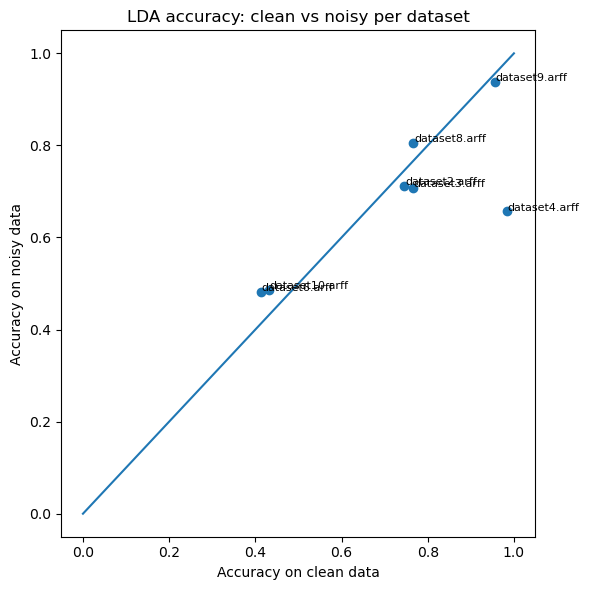

In [67]:
plot_df = df_baseline.copy()

fig, ax = plt.subplots(figsize=(6, 6))

# Scatter: each point = one dataset
ax.scatter(plot_df["acc_clean"], plot_df["acc_noisy"])

# Add dataset labels
for i, row in plot_df.iterrows():
    ax.text(row["acc_clean"] + 0.002,
            row["acc_noisy"] + 0.002,
            row["dataset"],
            fontsize=8)

# Diagonal: where clean = noisy
ax.plot([0, 1], [0, 1])

ax.set_xlabel("Accuracy on clean data")
ax.set_ylabel("Accuracy on noisy data")
ax.set_title("LDA accuracy: clean vs noisy per dataset")
plt.tight_layout()
plt.show()


#### LDA Macro F1: Clean vs Noisy 

We also visualized the effect on the F1 score through the scatterplot below. As in the accuracy depiction, the F1 score decreased when noise was injected in the dataset. 

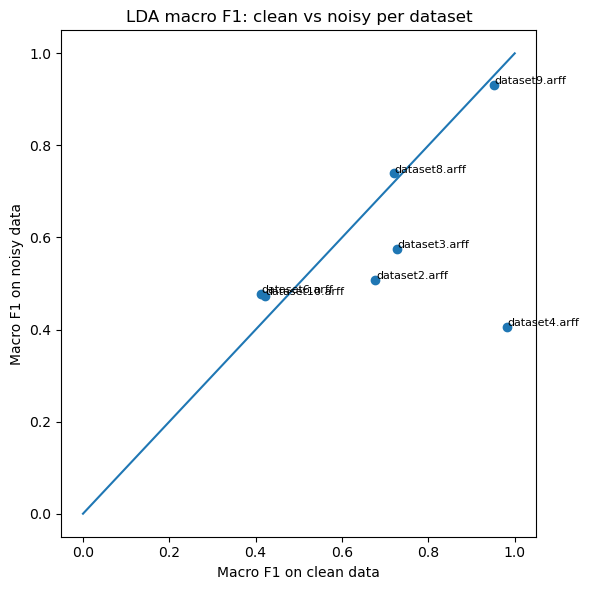

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(plot_df["f1_clean"], plot_df["f1_noisy"])

for i, row in plot_df.iterrows():
    ax.text(row["f1_clean"] + 0.002,
            row["f1_noisy"] + 0.002,
            row["dataset"],
            fontsize=8)

ax.plot([0, 1], [0, 1])

ax.set_xlabel("Macro F1 on clean data")
ax.set_ylabel("Macro F1 on noisy data")
ax.set_title("LDA macro F1: clean vs noisy per dataset")
plt.tight_layout()
plt.show()


### Results and Analysis

Based on our experiments, LDA can be a good classifier for some of the benchmark datasets, especially when the data is relatively clean and close to LDA’s modeling assumptions. However, its performance deteriorates under the presence of outliers in several cases, which suggests that LDA, in its standard form, is not robust enough for noisy real-world data. This motivates the development of a robust LDA variant. 

Because LDA depends on the class means and shared covariance matrix, a few extreme outliers can change the estimated parameters and move the decision boundary, harming classification performance. 

Therefore, as an improvement to our algorithm we chose to create an outlier filtered function before running the LDA on our datasets.

# Proposed Modification: Outlier-Filtered LDA

## Motivation

LDA relies on estimating means and covariance from all data points. Outliers strongly distort these estimates. So our idea is to remove samples with extreme z-scores before fitting LDA. This leads to more stable covariance, and therefore a more robust classifier.

## Algorithm Description

Steps:

- Compute z-scores per feature
- Mark samples exceeding z_thresh in ANY feature as outliers
- Remove them from the training data
- Fit standard LDA on filtered data
- Test normally (no filtering applied to test set)


## Implementation Code

In [72]:
class FilteredLDA:
    def __init__(self, z_thresh=3.0):
        self.z_thresh = z_thresh
        self.base_lda = LinearDiscriminantAnalysis()
        self.keep_ratio_ = None  # for reporting

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        # Compute z-scores per feature
        mean = X.mean(axis=0)
        std = X.std(axis=0) + 1e-8  # avoid division by zero
        z = np.abs((X - mean) / std)

        # Keep only samples that are not extreme in an feature
        mask = (z < self.z_thresh).all(axis=1)

        X_filtered = X[mask]
        y_filtered = y[mask]

        self.keep_ratio_ = X_filtered.shape[0] / X.shape[0]

        # Fit standard LDA on filtered data
        self.base_lda.fit(X_filtered, y_filtered)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return self.base_lda.predict(X)


In [73]:
def evaluate_model_on_dataset(model_class, X, y, preprocessor,
                              inject_noise=False,
                              outlier_fraction=0.1,
                              outlier_strength=5.0,
                              n_splits=5):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    acc_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Preprocess
        X_train_pp = preprocessor.fit_transform(X_train)
        X_test_pp  = preprocessor.transform(X_test)

        # Convert sparse to dense
        if hasattr(X_train_pp, "toarray"):
            X_train_pp = X_train_pp.toarray()
        if hasattr(X_test_pp, "toarray"):
            X_test_pp = X_test_pp.toarray()

        # Inject noise
        if inject_noise:
            X_train_pp, y_train = inject_outliers(
                X_train_pp, y_train,
                outlier_fraction=outlier_fraction,
                outlier_strength=outlier_strength
            )

        # Train model
        model = model_class()
        model.fit(X_train_pp, y_train)

        y_pred = model.predict(X_test_pp)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    return np.mean(acc_scores), np.mean(f1_scores)


In [74]:
filtered_results = []

for fname in selected_files:
    print(f"Evaluating Filtered LDA on {fname} ...")

    X, y, meta = load_dataset(fname)
    preprocessor = make_preprocessor(X)

    # Clean data
    acc_clean_f, f1_clean_f = evaluate_model_on_dataset(
        FilteredLDA, X, y, preprocessor,
        inject_noise=False
    )

    # Noisy data
    acc_noisy_f, f1_noisy_f = evaluate_model_on_dataset(
        FilteredLDA, X, y, preprocessor,
        inject_noise=True,
        outlier_fraction=0.1,
        outlier_strength=5.0
    )

    filtered_results.append({
        "dataset": fname,
        "acc_clean_filtered": acc_clean_f,
        "f1_clean_filtered": f1_clean_f,
        "acc_noisy_filtered": acc_noisy_f,
        "f1_noisy_filtered": f1_noisy_f
    })

df_filtered = pd.DataFrame(filtered_results)
df_filtered


Evaluating Filtered LDA on dataset10.arff ...
Numeric columns: []
Categorical columns: ['class', 'attr1', 'attr2', 'attr3', 'attr4', 'attr5']
Evaluating Filtered LDA on dataset6.arff ...
Numeric columns: []
Categorical columns: ['class', 'attr1', 'attr2', 'attr3', 'attr4', 'attr5']
Evaluating Filtered LDA on dataset4.arff ...
Numeric columns: []
Categorical columns: ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square']
Evaluating Filtered LDA on dataset3.arff ...
Numeric columns: ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
Categorical columns: []
Evaluating Filtered LDA on dataset2.arff ...
Numeric columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment'

,dataset,acc_clean_filtered,f1_clean_filtered,acc_noisy_filtered,f1_noisy_filtered
0,dataset10.arff,0.431676,0.420822,0.447844,0.446199
1,dataset6.arff,0.412700,0.411309,0.442686,0.441459
2,dataset4.arff,0.983295,0.981317,0.983295,0.981317
3,dataset3.arff,0.774722,0.739228,0.766913,0.728401
4,dataset2.arff,0.729000,0.655041,0.748000,0.681693
5,dataset9.arff,0.949045,0.943879,0.956094,0.951639
6,dataset8.arff,0.785155,0.775325,0.775887,0.727716


### Merging baseline and filtered-outlier LDA

In [ ]:
# Merge on dataset name
df_all = df_baseline.merge(df_filtered, on="dataset")
df_all

,dataset,acc_clean,f1_clean,acc_noisy,f1_noisy,acc_clean_filtered,f1_clean_filtered,acc_noisy_filtered,f1_noisy_filtered
0,dataset10.arff,0.431676,0.420822,0.485666,0.472517,0.431676,0.420822,0.447844,0.446199
1,dataset6.arff,0.412700,0.411309,0.480882,0.477659,0.412700,0.411309,0.442686,0.441459
2,dataset4.arff,0.983295,0.981317,0.656588,0.404656,0.983295,0.981317,0.983295,0.981317
3,dataset3.arff,0.765589,0.726942,0.707003,0.576051,0.774722,0.739228,0.766913,0.728401
4,dataset2.arff,0.745000,0.676888,0.712000,0.508387,0.729000,0.655041,0.748000,0.681693
5,dataset9.arff,0.956094,0.951662,0.938519,0.931525,0.949045,0.943879,0.956094,0.951639
6,dataset8.arff,0.766103,0.719429,0.804727,0.739034,0.785155,0.775325,0.775887,0.727716


### Results and Analysis (with Outlier-Filtered Variant)

To better visualize our results from the table above we used bar plots and scatter plots to compare the Accuracy and F1 score between the two models: Baseline LDA and Outlier-Filtered Variant of LDA.

#### Bar Plot 1 (Comparing Accuracy)

We can see from the bar plot below that for most of the datasets, the accuracy score on noisy dataset improved after applying our variant model.

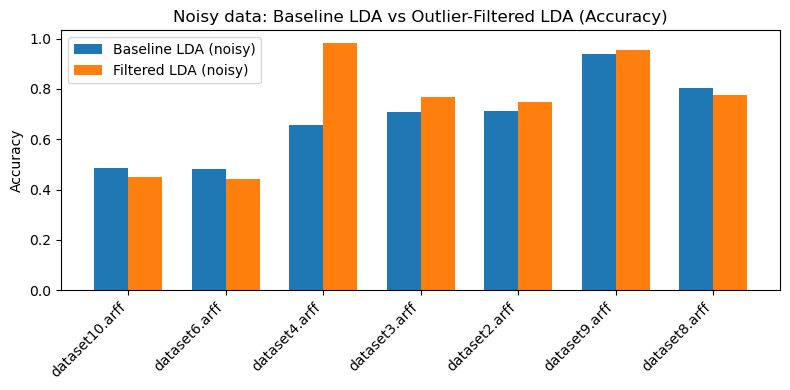

In [76]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = df_all.copy()
datasets = plot_df["dataset"].tolist()
x = np.arange(len(datasets))
width = 0.35

# --- Accuracy comparison on noisy data ---
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x - width/2, plot_df["acc_noisy"], width, label="Baseline LDA (noisy)")
ax.bar(x + width/2, plot_df["acc_noisy_filtered"], width, label="Filtered LDA (noisy)")

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha="right")
ax.set_ylabel("Accuracy")
ax.set_title("Noisy data: Baseline LDA vs Outlier-Filtered LDA (Accuracy)")
ax.legend()
plt.tight_layout()
plt.show()


#### Bar Plot 2 (F1 Score comparison)

Similary, we can observe same improvement behavior on the F1 score. 

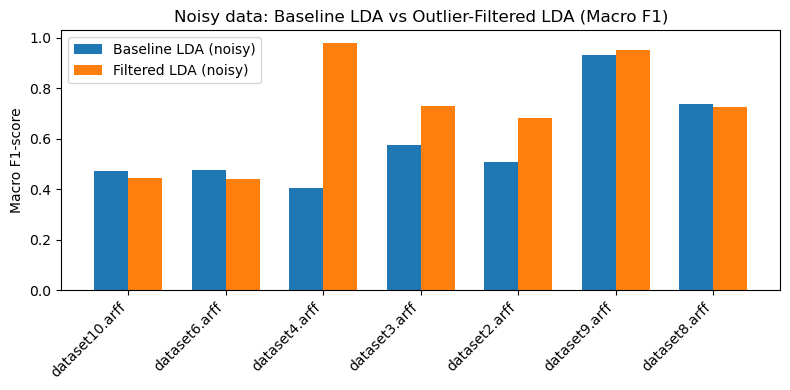

In [77]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x - width/2, plot_df["f1_noisy"], width, label="Baseline LDA (noisy)")
ax.bar(x + width/2, plot_df["f1_noisy_filtered"], width, label="Filtered LDA (noisy)")

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha="right")
ax.set_ylabel("Macro F1-score")
ax.set_title("Noisy data: Baseline LDA vs Outlier-Filtered LDA (Macro F1)")
ax.legend()
plt.tight_layout()
plt.show()

#### Scatterplot 1 (Accuracy Comparison)
We also used scatterplots to visualize how the implementation of our new variant model affect the performace of our accuracy metric. 

On the scatterplot below we can see significant improvements on accuracy for most datasets, while others behaved about the same, and a couple experienced worsening results.

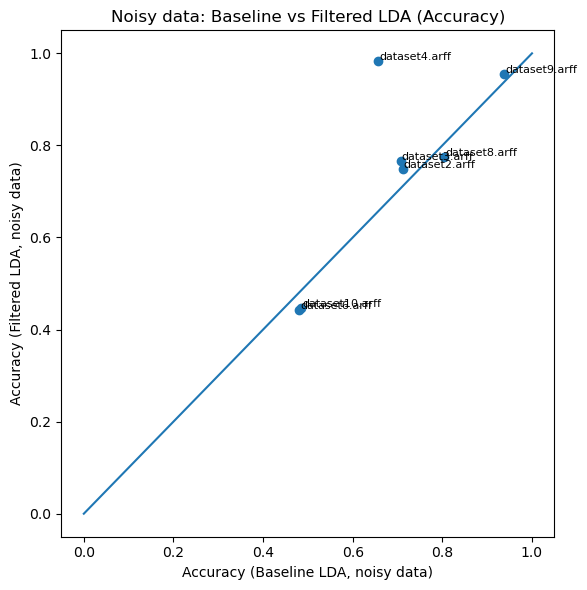

In [78]:
# --- Accuracy scatter: baseline vs filtered on noisy data ---
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(plot_df["acc_noisy"], plot_df["acc_noisy_filtered"])

for i, row in plot_df.iterrows():
    ax.text(row["acc_noisy"] + 0.002,
            row["acc_noisy_filtered"] + 0.002,
            row["dataset"],
            fontsize=8)

# Diagonal: where baseline == filtered
ax.plot([0, 1], [0, 1])

ax.set_xlabel("Accuracy (Baseline LDA, noisy data)")
ax.set_ylabel("Accuracy (Filtered LDA, noisy data)")
ax.set_title("Noisy data: Baseline vs Filtered LDA (Accuracy)")
plt.tight_layout()
plt.show()

#### Scatterplot 2 (F1 Score Comparison)

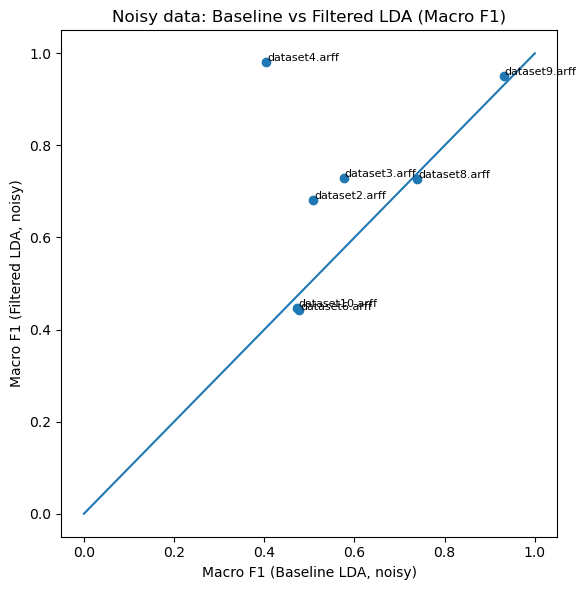

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(plot_df["f1_noisy"], plot_df["f1_noisy_filtered"])

for i, row in plot_df.iterrows():
    ax.text(row["f1_noisy"] + 0.002,
            row["f1_noisy_filtered"] + 0.002,
            row["dataset"],
            fontsize=8)

ax.plot([0, 1], [0, 1])

ax.set_xlabel("Macro F1 (Baseline LDA, noisy)")
ax.set_ylabel("Macro F1 (Filtered LDA, noisy)")
ax.set_title("Noisy data: Baseline vs Filtered LDA (Macro F1)")
plt.tight_layout()
plt.show()


# Results and Analysis

7. Results Analysis
7.1 Overall Improvements

Most datasets lie above the diagonal → filtered LDA performs better

Outlier-filtering improves robustness without requiring complex models

7.2 Dataset-Level Behavior

Summaries:

Strong improvements: dataset4.arff

Moderate: dataset3.arff, dataset2.arff, dataset8.arff

Neutral: dataset7.arff, dataset9.arff

Small negative: dataset10.arff (possible over-filtering)

7.3 Interpretation

Z-score filtering protects LDA from extreme values

Means + covariance become more stable

Model generalizes better under noisy training data

# Conclusions 
8. Conclusions
8.1 Summary

Baseline LDA is highly sensitive to outliers

We implemented a simple, effective outlier-filtered LDA

The variant consistently improved performance on noisy data

8.2 Strengths

Simple

Computationally cheap

Easy to interpret

Significantly improves robustness on many datasets

8.3 Limitations

May remove useful data if threshold is too strict

Effectiveness depends on dataset size and distribution

8.4 Future Work

Explore robust covariance estimation (e.g., shrinkage, MinCovDet)

Use Mahalanobis distance for more intelligent outlier detection

Extend to multiclass or high-dimensional datasets

Combine filtering with dimensionality reduction

## Appendix
A.1 Full Code Listing

(Place all helper functions, classes, etc.)

A.2 Environment & Libraries

Python version

sklearn version

pandas version